![Logo TUBAF](https://tu-freiberg.de/sites/default/files/media/freiberger-alumni-netzwerk-6127/wbm_orig_rgb_0.jpg)

Exercise material of the MSc-level course **Advanced Soil Mechanics**.
Held at Technische Universität Bergakademie Freiberg.

Comments to:

*Prof. Dr. Thomas Nagel  
Chair of Soil Mechanics and Foundation Engineering  
Geotechnical Institute  
Technische Universität Bergakademie Freiberg.*

https://tu-freiberg.de/en/fakultaet3/gt/soilmechanics


# Kinematische Elemente Methode und Überlegungen zu Sicherheitsfaktoren

Hier werden aus starren Teilkörpern zusammengesetzte Bruchmechanismen betrachtet, die entlang gemeinsamer Gleitfugen translatorisch aneinander abgleiten. Rotationen werden also nicht betrachtet, das Momentengleichgewicht nicht eingefordert (Nachteil). Kleinere kinematische Inkompatibilitäten (Zwängungen) an den Kanten werden ebenso vernachlässigt. Vorteilhaft ist dennoch die Vielfältigkeit des Verfahrens, mit dem realistischere Bruchmechanismen erfasst werden können.



In [1]:
import numpy as np #numerical methods
import matplotlib.pyplot as plt #plotting
import pandas as pd
import scipy as sp
from scipy import optimize

#Some plot settings
import plot_functions.plot_settings
%run plot_functions/KEM_plots.ipynb

Wir definieren zunächst die Geometrie des Problems, legen also die kinematischen Elemente des Bruchmechanismus fest.

In [2]:
geometry = pd.DataFrame(np.array([[1,2,3,4,5,6,7,8,9],
                                  [6.9,5.5,4.63,5.88,4.6,3.78,2.5,2.36,0.0],
                                  [4.0,4.0,2.84,1.68,-0.2,1.71,0.0,-1.1,0.0]]).T,
                   columns=['Pkt', 'x / m', 'y / m'])
geometry

,Pkt,x / m,y / m
0,1.0,6.90,4.00
1,2.0,5.50,4.00
2,3.0,4.63,2.84
3,4.0,5.88,1.68
4,5.0,4.60,-0.20
5,6.0,3.78,1.71
6,7.0,2.50,0.00
7,8.0,2.36,-1.10
8,9.0,0.00,0.00


In [3]:
#Achtung: Nummerierung im Umlaufsinn!
block1 = define_element(geometry,[1,2,3,4])
block2 = define_element(geometry,[4,3,6,5])
block3 = define_element(geometry,[5,6,7,8])
block4 = define_element(geometry,[8,7,9])

In der Darstellung ergibt sich folgende Böschungsgeometrie.

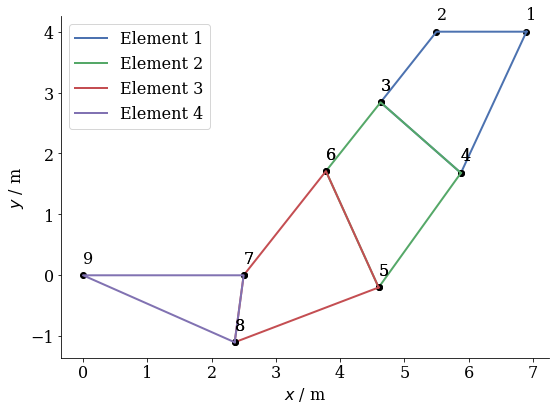

In [4]:
plot_blocks([block1,block2,block3,block4])

## Kinematik, Geschwindigkeitsplan

Zunächst betrachten wir die (vereinfachte) Kinematik des Systems und ermitteln den Geschwindigkeitsplan. Alle Geschwindigkeiten sind determiniert, sobald die Geschwindigkeit eines Körpers vorgegeben wird. Das System hat also einen Freiheitsgrad. Die Bewegungsrichtung der einzelnen Gleitkörper sei durch die Gleitfugen vorgegeben. Mit dieser Information lässt sich also der Geschwindigkeitsplan zeichnen, aus dem sich dann auch die Wirkungsrichtung von Kohäsions- und Reibungskräften in den Gleitfugen ablesen lässt.

![KEM.png](https://raw.githubusercontent.com/nagelt/Teaching_Scripts/master/Images/KEM.png)
[Bild aus: Kolymbas (2016). Geotechnik. Springer Vieweg.]

Geben wir also ohne Einschränkung der Allgemeinheit $\vec{v}_{14}$ so vor, dass $|\vec{v}_{14}| = 1\,$m/s gilt. Die gleitfugenparallelen Geschwindigkeiten $\vec{v}_{45}$, $\vec{v}_{58}$ und $\vec{v}_{89}$ kennen wir zunächst nur der Richtung nach. Die beiden Indizes ergeben sich aus den Knoten der Gleitfuge, die Reihenfolge gibt die Bewegungsrichtung an.

In [5]:
v_14 = line_of_Q(geometry, np.eye(2),1,4)
e_v45 = line_of_Q(geometry, np.eye(2),4,5)
e_v58 = line_of_Q(geometry, np.eye(2),5,8)
e_v89 = line_of_Q(geometry, np.eye(2),8,9)

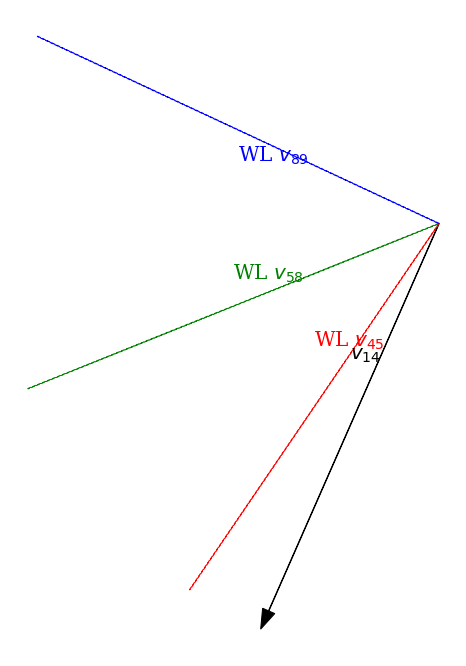

In [6]:
scale = 0.3
fig, ax = plt.subplots(figsize=(12,12))
vec_from_by(ax,delta=v_14,label='$v_{14}$',scale=scale)
#
line_from_by(ax,delta=e_v45,scale=1,ls='--',label='WL ${v_{45}}$',col='red')
line_from_by(ax,delta=e_v58,scale=1,ls='--',label='WL ${v_{58}}$',col='green')
line_from_by(ax,delta=e_v89,scale=1,ls='--',label='WL ${v_{89}}$',col='blue')
#
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

Die Länge der Vektoren ergibt sich nun daraus, dass die Relativbewegung zweier Körper wiederum durch die gemeinsame Gleitfuge vorgegeben ist. Die Schnittpunkte der Wirkungslinien bestimmen die Beträge der Relativgeschwindigkeiten (Maßstab beachten).

In [7]:
e_v34 = line_of_Q(geometry, np.eye(2),3,4)
e_v65 = line_of_Q(geometry, np.eye(2),6,5)
e_v78 = line_of_Q(geometry, np.eye(2),7,8)

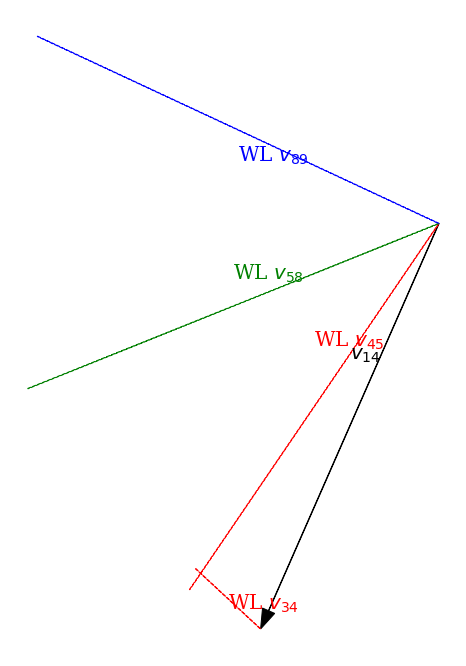

In [8]:
scale = 0.3
fig, ax = plt.subplots(figsize=(12,12))
vec_from_by(ax,delta=v_14,label='$v_{14}$',scale=scale)
#
line_from_by(ax,delta=e_v45,scale=1,ls='--',label='WL ${v_{45}}$',col='red')
line_from_by(ax,delta=e_v58,scale=1,ls='--',label='WL ${v_{58}}$',col='green')
line_from_by(ax,delta=e_v89,scale=1,ls='--',label='WL ${v_{89}}$',col='blue')
#
line_from_by(ax,fro=v_14,delta=-e_v34,scale=0.2,ls='--',label='WL ${v_{34}}$',col='red')
#line_from_by(ax,delta=e_v56,scale=0.5,ls='--',label='WL ${v_{56}}$')
#line_from_by(ax,delta=e_v78,scale=1,ls='--',label='WL ${v_{78}}$')
#
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

Graphisch können wir uns nun von Schnittpunkt zu Schnittpunkt hangeln.

Mathematisch suchen wir also die Lösung für folgende Gleichungen (6 Gleichungen für 6 Unbekannte):

\begin{align}
    \vec{0} &= f_{45} \vec{e}_{v_{45}} + f_{34} \vec{e}_{v_{34}} - \vec{v}_{14}
    \\
    \vec{0} &= f_{58} \vec{e}_{v_{58}} + f_{56} \vec{e}_{v_{56}} - f_{45} \vec{e}_{v_{45}}
    \\
    \vec{0} &= f_{89} \vec{e}_{v_{89}} + f_{78} \vec{e}_{v_{78}} - f_{58} \vec{e}_{v_{58}}
\end{align}

Wir suchen also die skalaren Faktoren $f_{ij}$, die die Richtungsvectoren $\vec{e}_{v_{ij}}$ so skalieren, dass sich die Geschwindigkeiten gemäß des vorgegebenen Bruchmechanismus addieren.

Wir können nun entweder die Gleichungen nacheinander nach den Unbekannten auflösen, oder alles in ein Gleichungssystem schreiben.

$$
\begin{pmatrix}
    e_{v_{45},x} & e_{v_{34},x} & 0 & 0 & 0 & 0 \\
    e_{v_{45},y} & e_{v_{34},y} & 0 & 0 & 0 & 0 \\
    -e_{v_{45},x} & 0 & e_{v_{58},x} & e_{v_{56},x} & 0 & 0 \\
    -e_{v_{45},y} & 0 & e_{v_{58},y} & e_{v_{56},y} & 0 & 0 \\
    0 & 0 & -e_{v_{58},x} & 0 & e_{v_{89},x} & e_{v_{78},x} \\
    0 & 0 & -e_{v_{58},y} & 0 & e_{v_{89},y} & e_{v_{78},y} \\
    \end{pmatrix}
    \begin{pmatrix}
    f_{45}\\
    f_{34}\\
    f_{58}\\
    f_{56}\\
    f_{89}\\
    f_{78}
    \end{pmatrix}
    =
    \begin{pmatrix}
    v_{14,x}\\
    v_{14,y}\\
    0\\
    0\\
    0\\
    0
    \end{pmatrix}
$$

Man beachte, wie sich die gegebene Information (rechte Seite, $\vec{v}_{14}$) durch die drei Vektorgleichungen fortpflanzt (über die Terme mit Vorzeichenwechsel).

In [9]:
b_v = np.append(v_14,np.zeros((4,1)))
A_v = np.zeros((6,6))
A_v[0:2,0] = e_v45
A_v[0:2,1] = e_v34
#
A_v[2:4,0] = -e_v45
A_v[2:4,2] = e_v58
A_v[2:4,3] = e_v65
#
A_v[4:6,2] = -e_v58
A_v[4:6,4] = e_v89
A_v[4:6,5] = e_v78

In [10]:
f_v = np.linalg.solve(A_v,b_v)

In [11]:
v_45 = f_v[0]*e_v45
v_34 = f_v[1]*e_v34
v_58 = f_v[2]*e_v58
v_65 = f_v[3]*e_v65
v_89 = f_v[4]*e_v89
v_78 = f_v[5]*e_v78

Nun können wir den gesamten Geschwindigkeitsplan zeichnen, und so die Lösung graphisch bestätigen.

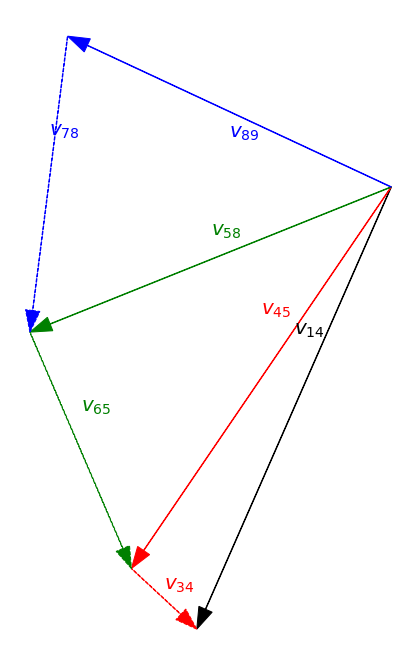

In [12]:
scale = 0.3
fig, ax = plt.subplots(figsize=(12,12))
vec_from_by(ax,delta=v_14,label='$v_{14}$',scale=scale)
#
vec_from_by(ax,delta=v_45,scale=scale,label='${v_{45}}$',col='red')
vec_from_by(ax,delta=v_58,scale=scale,label='${v_{58}}$',col='green')
vec_from_by(ax,delta=v_89,scale=scale,label='${v_{89}}$',col='blue')
#
vec_from_by(ax,fro=v_45,delta=v_34,scale=scale,label='${v_{34}}$',col='red',ls='--')
vec_from_by(ax,fro=v_58,delta=v_65,scale=scale,label='${v_{65}}$',col='green',ls='--')
vec_from_by(ax,fro=v_89,delta=v_78,scale=scale,label='${v_{78}}$',col='blue',ls='--')
#
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

## Statik, Kräfteplan

Jetzt können wir weitere wesentliche Größen ausrechnen. Genauer gesagt, können wir die Gewichtskräfte der einzelnen kinematischen Elemente aus ihren Flächeninhalten ableiten. Dazu legen wir die wesentlichen Materialeigenschaften fest.

In [13]:
#Wichte in kN/m³
gamma = 16.
#Kohäsion in kN/m²
c = 5
#Reibungswinkel in rad
phi = np.deg2rad(30)

In [14]:
data = {'A / m²': np.array([block_area(block1),block_area(block2),block_area(block3),block_area(block4)])} #in m

In [15]:
data['G / kN/m'] = data['A / m²']*gamma

In [16]:
blockdata = pd.DataFrame(data)
blockdata

,A / m²,G / kN/m
0,2.85360,45.6576
1,3.19245,51.0792
2,3.09250,49.4800
3,1.37500,22.0000


Am unteren Körper lässt sich direkt das Kräftegleichgewicht konstruieren: Wir kennen die Gewichtskraft sowie die Wirkungslinien der Reibungs- und Kohäsionskräfte in den beiden Gleitfugen. Der Richtungssinn der letzteren beiden Kräfte folgt aus dem Geschwindigkeitsplan. Außerdem sind die Normalenkräfte anzusetzen. Normalkraft $N$ und Reibungskraft $R$ werden zur Gleitfugenresultierenden $Q$ zuammengefasst und aus dem Kräftegleichgewicht bestimmt, während sich die Kohäsionskräfte $C$ aus dem Bruchmechanismus ableiten.

## Kräftegleichgewicht am Element 4

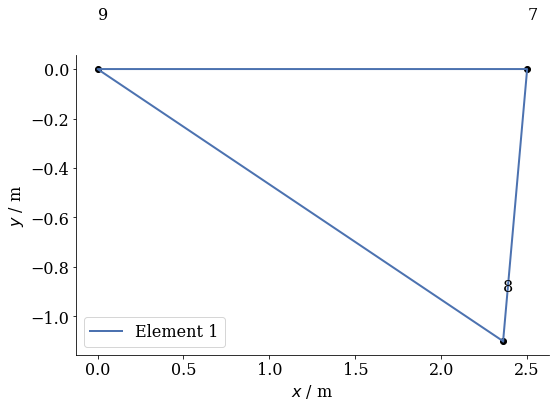

In [17]:
plot_blocks([block4])

Sammeln wir zunächst die aus der Geometrie und den Materialeigenschaften bekannten Vektoren $\vec{G}_4$, $\vec{C}_{98}$ und $\vec{C}_{78}$. Dabei gelte an Grenzflächen die Konvention $\vec{F}_{\text{von}\,\text{bis}}$, wodurch über die Reihenfolge der Indizes die Wirkrichtung festgelegt ist.

In [18]:
G_4 = gravity_vector(blockdata,4)
G_4

array([  0., -22.])

In [19]:
C_98 = cohesion(c,geometry,9,8)
print("Die Kohäsionskraft beträgt %.2f kN/m" %np.linalg.norm(C_98))
C_98

Die Kohäsionskraft beträgt 13.02 kN/m


array([11.8, -5.5])

In [20]:
C_78 = cohesion(c,geometry,7,8)
print("Die Kohäsionskraft beträgt %.2f kN/m" %np.linalg.norm(C_78))
C_78

Die Kohäsionskraft beträgt 5.54 kN/m


array([-0.7, -5.5])

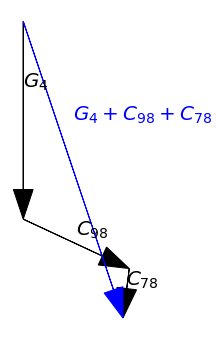

In [21]:
scale = np.linalg.norm(G_4)
fig, ax = plt.subplots()
vec_from_by(ax,delta=G_4,label='$G_4$',scale=scale)
vec_from_by(ax,fro=G_4,delta=C_98,label='$C_{98}$',scale=scale)
vec_from_by(ax,fro=G_4+C_98,delta=C_78,label='$C_{78}$',scale=scale)
vec_from_by(ax,delta=G_4+C_98+C_78,label='$G_4 + C_{98} + C_{78}$',scale=scale,col='blue')
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

Ausgehend von der Wirkungsrichtung von $\vec{C}_{\text{von}\,\text{bis}}$ ergibt sich die Wirkungsrichtung der Gleitfugenresultierenden $\vec{Q}_{\text{von}\,\text{bis}}$ durch Rotation um $90° - \varphi$ gegen den Uhrzeigersinn (mathematisch positiv) oder im Uhrzeigersinn (mathematisch negativ), da $\vec{Q}$ gegenüber dem Lot auf die Gleitfläche (Wirkungslinie von $\vec{N}$) um den Reibungswinkel $\varphi$ geneigt ist und ebenso wie $\vec{C}$ der Bewegung des Gleitkörpers entgegen wirkt.

Zur Rotation von Vektoren werden Rotationsmatrizen festgelegt.

In [22]:
beta = np.deg2rad(90) - phi
Rp = np.array([[np.cos(beta),-np.sin(beta)],[np.sin(beta),np.cos(beta)]])
Rn = np.array([[np.cos(-beta),-np.sin(-beta)],[np.sin(-beta),np.cos(-beta)]])

In der Darstellung siht das wie folgt aus:

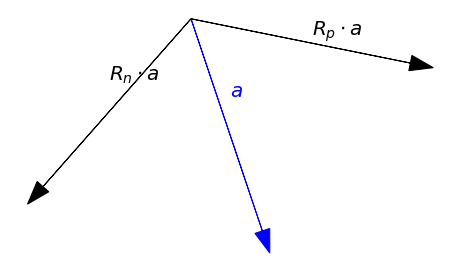

In [23]:
scale = np.linalg.norm(G_4)
fig, ax = plt.subplots()
a= G_4+C_98+C_78
vec_from_by(ax,delta=a,label='$a$',scale=scale,col='blue')
vec_from_by(ax,delta=Rp.dot(a),label='$R_p \cdot a$',scale=scale)
vec_from_by(ax,delta=Rn.dot(a),label='$R_n \cdot a$',scale=scale)
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

Nun können wir die Wirkungslinien von $\vec{Q}_{98}$ und $\vec{Q}_{78}$ bestimmen. Diese sind durch die folgenden Einheitsvektoren $\vec{e}_{Q_{78}}$ und $\vec{e}_{Q_{98}}$ gegeben.

In [24]:
e_Q98 = line_of_Q(geometry,Rp,9,8)
e_Q78 = line_of_Q(geometry,Rn,7,8)

Aus dem Schnittpunkt beider Wirkungslinien ergeben sich graphisch die Beträge der gesuchten Kraftvektoren (Zeichenmaßstab beachten!).

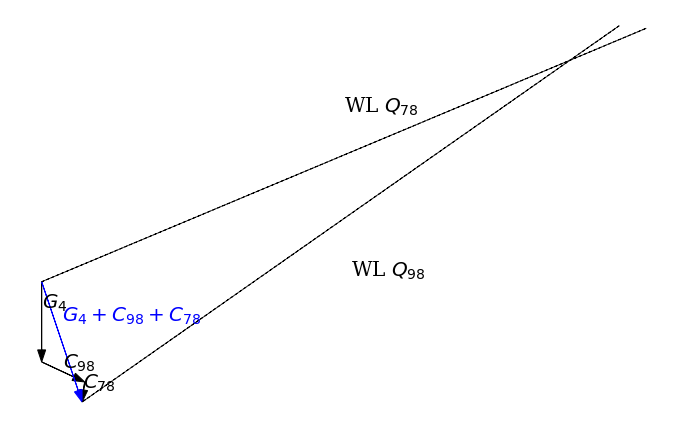

In [25]:
scale = np.linalg.norm(G_4)
fig, ax = plt.subplots(figsize=(12,12))
vec_from_by(ax,delta=G_4,label='$G_4$',scale=scale)
vec_from_by(ax,fro=G_4,delta=C_98,label='$C_{98}$',scale=scale)
vec_from_by(ax,fro=G_4+C_98,delta=C_78,label='$C_{78}$',scale=scale)
vec_from_by(ax,delta=G_4+C_98+C_78,label='$G_4 + C_{98} + C_{78}$',scale=scale,col='blue')
#
line_from_by(ax,-e_Q78*180,e_Q78,scale=180,ls='--',label='WL ${Q_{78}}$')
line_from_by(ax,G_4+C_98+C_78,e_Q98,scale=180,ls='--',label='WL ${Q_{98}}$')
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

Mathematisch gilt es, die Skalierfaktoren $f_i$ zu bestimmen, so dass gilt:

$$
    \vec{0} = \vec{G}_4 + \vec{C}_{98} + \vec{C}_{78} + f_{78} \vec{e}_{Q_{78}} + f_{98} \vec{e}_{Q_{78}}
$$

Somit stehen zwei Gleichungen für die 2 Unbekannten zur Verfügung. Wir stellen die Gleichung in die Form

$$
    A_{ij} f_j = b_i 
$$

um (Sie können auch beide Gleichungen ausschreiben und sie direkt umstellen).

In [26]:
b4 = -(G_4 + C_98 + C_78)

In [27]:
A4 = np.array([e_Q78,e_Q98]).T

In [28]:
f4 = np.linalg.solve(A4,b4)

In [29]:
Q_78 = e_Q78 * f4[0]
print("Die Resultierende beträgt %.2f kN/m" %np.linalg.norm(Q_78))

Die Resultierende beträgt 157.24 kN/m


In [30]:
Q_98 = e_Q98 * f4[1]
print("Die Resultierende beträgt %.2f kN/m" %np.linalg.norm(Q_98))

Die Resultierende beträgt 163.49 kN/m


Mit der graphischen Darstellung des Ergebnisses überprüfen wir, ob wir richtig gerechnet haben.

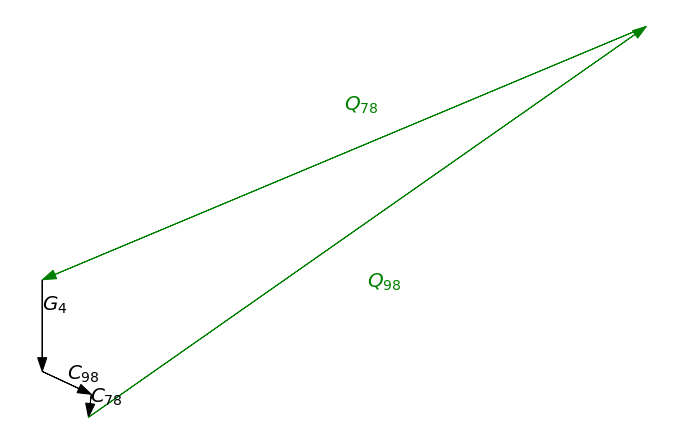

In [31]:
scale = np.linalg.norm(G_4)
fig, ax = plt.subplots(figsize=(12,12))
vec_from_by(ax,delta=G_4,label='$G_4$',scale=scale)
vec_from_by(ax,fro=G_4,delta=C_98,label='$C_{98}$',scale=scale)
vec_from_by(ax,fro=G_4+C_98,delta=C_78,label='$C_{78}$',scale=scale)
#
vec_from_by(ax,-Q_78,Q_78,scale=scale,label='${Q_{78}}$',col='green')
vec_from_by(ax,G_4+C_98+C_78,Q_98,scale=scale,label='${Q_{98}}$',col='green')
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

## Kräftegleichgewicht an Element 3

Nun, da der Prozess klar ist, wiederholen wir ihn und hangeln uns von Element zu Element.

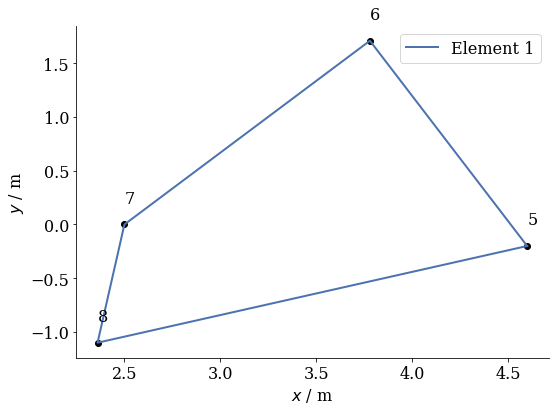

In [32]:
plot_blocks([block3])

Wegen des Schnittprinzips (Kräftegleichgewicht) sind neben der Gewichtskraft bereits folgende Kräfte bekannt: $C_{87} = -C_{78}$, $Q_{87} = - Q_{78}$. Daneben können wir die Kohäsionskräfte $C_{85}$ und $C_{65}$ aus der Geometrie des Gleitkörpers ableiten.

In [33]:
G_3 = gravity_vector(blockdata,3)
C_87 = - C_78
Q_87 = - Q_78

In [34]:
C_85 = cohesion(c,geometry,8,5)
print("Die Kohäsionskraft beträgt %.2f kN/m" %np.linalg.norm(C_85))
C_85

Die Kohäsionskraft beträgt 12.07 kN/m


array([11.2,  4.5])

In [35]:
C_65 = cohesion(c,geometry,6,5)
print("Die Kohäsionskraft beträgt %.2f kN/m" %np.linalg.norm(C_65))
C_65

Die Kohäsionskraft beträgt 10.39 kN/m


array([ 4.1 , -9.55])

Die die Wirkungslinien von $Q_{85}$ und $Q_{65}$ charakterisierenden Einheitsvektoren bestimmen wir wieder durch Rotation der Wirkungslinien der Kohäsionskräfte.

In [36]:
e_Q85 = line_of_Q(geometry,Rp,8,5)
e_Q65 = line_of_Q(geometry,Rn,6,5)

Das können wir nun graphisch darstellen.

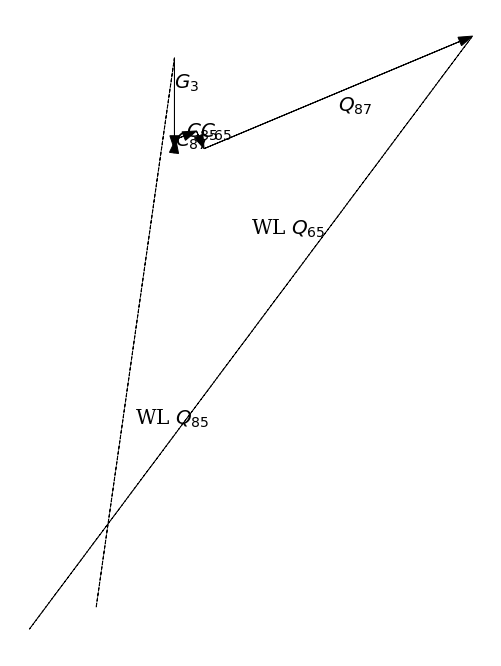

In [37]:
scale = np.linalg.norm(G_3)
fig, ax = plt.subplots(figsize=(12,12))
vec_from_by(ax,delta=G_3,label='$G_3$',scale=scale)
vec_from_by(ax,fro=G_3,delta=C_87,label='$C_{87}$',scale=scale)
vec_from_by(ax,fro=G_3+C_87,delta=C_85,label='$C_{85}$',scale=scale)
vec_from_by(ax,fro=G_3+C_87+C_85,delta=C_65,label='$C_{65}$',scale=scale)
vec_from_by(ax,fro=G_3+C_87+C_85+C_65,delta=Q_87,label='$Q_{87}$',scale=scale)
#
line_from_by(ax,-e_Q85*300,e_Q85,scale=300,ls='--',label='WL ${Q_{85}}$')
line_from_by(ax,G_3+C_87+C_85+C_65+Q_87,e_Q65,scale=400,ls='--',label='WL ${Q_{65}}$')
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

Nun lösen wir wieder folgende Vektorgleichung zur Bestimmung des Schnittpunktes der beiden Wirkungslinien:

$$
    \vec{0} = \vec{G}_3 + \vec{C}_{87} + \vec{C}_{85} + \vec{C}_{65} + Q_{87} + f_{85} \vec{e}_{Q_{85}} + f_{65} \vec{e}_{Q_{65}}
$$

In [38]:
b3 = -(G_3 + C_87 + C_85 + C_65 + Q_87)

In [39]:
A3 = np.array([e_Q85,e_Q65]).T

In [40]:
f3 = np.linalg.solve(A3,b3)

In [41]:
Q_85 = e_Q85 * f3[0]
print("Die Resultierende beträgt %.2f kN/m" %np.linalg.norm(Q_85))

Die Resultierende beträgt 254.29 kN/m


In [42]:
Q_65 = e_Q65 * f3[1]
print("Die Resultierende beträgt %.2f kN/m" %np.linalg.norm(Q_65))

Die Resultierende beträgt 328.94 kN/m


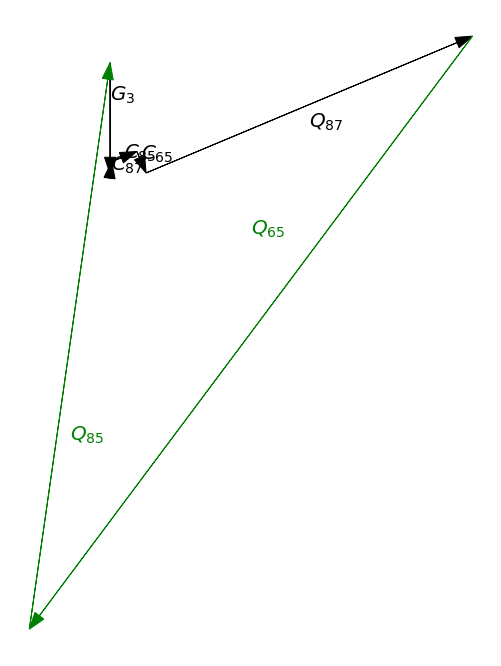

In [43]:
scale = np.linalg.norm(G_3)
fig, ax = plt.subplots(figsize=(12,12))
vec_from_by(ax,delta=G_3,label='$G_3$',scale=scale)
vec_from_by(ax,fro=G_3,delta=C_87,label='$C_{87}$',scale=scale)
vec_from_by(ax,fro=G_3+C_87,delta=C_85,label='$C_{85}$',scale=scale)
vec_from_by(ax,fro=G_3+C_87+C_85,delta=C_65,label='$C_{65}$',scale=scale)
vec_from_by(ax,fro=G_3+C_87+C_85+C_65,delta=Q_87,label='$Q_{87}$',scale=scale)
#
vec_from_by(ax,-Q_85,Q_85,scale=scale,label='${Q_{85}}$',col='green')
vec_from_by(ax,G_3+C_87+C_85+C_65+Q_87,Q_65,scale=scale,label='${Q_{65}}$',col='green')
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

## Kräftegleichgewicht an Element 2

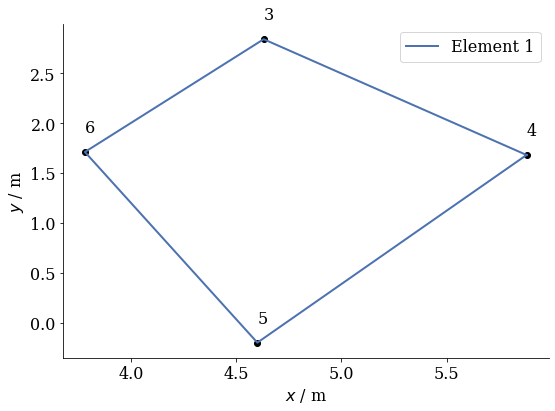

In [44]:
plot_blocks([block2])

Wegen des Schnittprinzips (Kräftegleichgewicht) sind neben der Gewichtskraft bereits folgende Kräfte bekannt: $C_{56} = -C_{65}$, $Q_{56} = - Q_{65}$. Daneben können wir die Kohäsionskräfte $C_{54}$ und $C_{34}$ aus der Geometrie des Gleitkörpers ableiten.

In [45]:
G_2 = gravity_vector(blockdata,2)
C_56 = - C_65
Q_56 = - Q_65

In [46]:
C_54 = cohesion(c,geometry,5,4)
print("Die Kohäsionskraft beträgt %.2f kN/m" %np.linalg.norm(C_54))
C_54

Die Kohäsionskraft beträgt 11.37 kN/m


array([6.4, 9.4])

In [47]:
C_34 = cohesion(c,geometry,3,4)
print("Die Kohäsionskraft beträgt %.2f kN/m" %np.linalg.norm(C_34))
C_34

Die Kohäsionskraft beträgt 8.53 kN/m


array([ 6.25, -5.8 ])

Die die Wirkungslinien von $Q_{54}$ und $Q_{34}$ charakterisierenden Einheitsvektoren bestimmen wir wieder durch Rotation der Wirkungslinien der Kohäsionskräfte.

In [48]:
e_Q54 = line_of_Q(geometry,Rp,5,4)
e_Q34 = line_of_Q(geometry,Rn,3,4)

Das können wir nun graphisch darstellen.

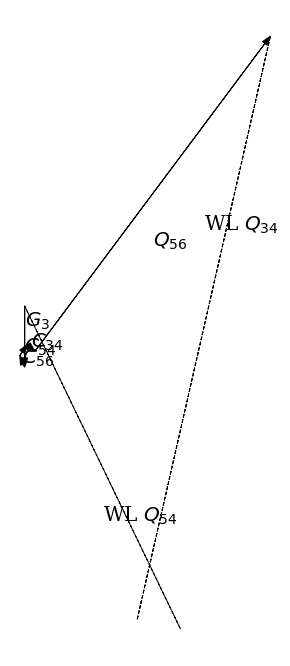

In [49]:
scale = np.linalg.norm(G_2)
fig, ax = plt.subplots(figsize=(12,12))
vec_from_by(ax,delta=G_2,label='$G_3$',scale=scale)
vec_from_by(ax,fro=G_2,delta=C_56,label='$C_{56}$',scale=scale)
vec_from_by(ax,fro=G_2+C_56,delta=C_54,label='$C_{54}$',scale=scale)
vec_from_by(ax,fro=G_2+C_56+C_54,delta=C_34,label='$C_{34}$',scale=scale)
vec_from_by(ax,fro=G_2+C_56+C_54+C_34,delta=Q_56,label='$Q_{56}$',scale=scale)
#
line_from_by(ax,-e_Q54*300,e_Q54,scale=300,ls='--',label='WL ${Q_{54}}$')
line_from_by(ax,G_2+C_56+C_54+C_34+Q_56,e_Q34,scale=500,ls='--',label='WL ${Q_{34}}$')
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

Nun lösen wir wieder folgende Vektorgleichung zur Bestimmung des Schnittpunktes der beiden Wirkungslinien:

$$
    \vec{0} = \vec{G}_2 + \vec{C}_{56} + \vec{C}_{54} + \vec{C}_{34} + Q_{56} + f_{54} \vec{e}_{Q_{54}} + f_{34} \vec{e}_{Q_{34}}
$$

In [50]:
b2 = -(G_2 + C_56 + C_54 + C_34 + Q_56)

In [51]:
A2 = np.array([e_Q54,e_Q34]).T

In [52]:
f2 = np.linalg.solve(A2,b2)

In [53]:
Q_54 = e_Q54 * f2[0]
print("Die Resultierende beträgt %.2f kN/m" %np.linalg.norm(Q_54))

Die Resultierende beträgt 240.47 kN/m


In [54]:
Q_34 = e_Q34 * f2[1]
print("Die Resultierende beträgt %.2f kN/m" %np.linalg.norm(Q_34))

Die Resultierende beträgt 453.56 kN/m


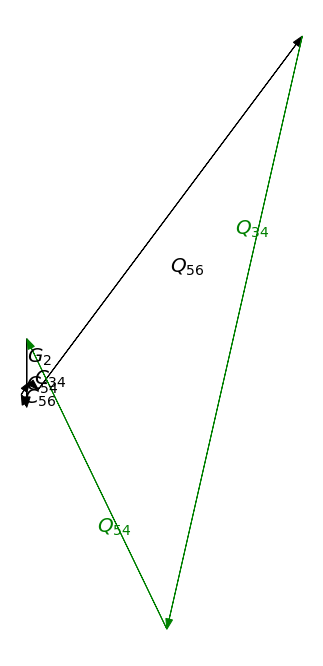

In [55]:
scale = np.linalg.norm(G_2)
fig, ax = plt.subplots(figsize=(12,12))
vec_from_by(ax,delta=G_2,label='$G_2$',scale=scale)
vec_from_by(ax,fro=G_2,delta=C_56,label='$C_{56}$',scale=scale)
vec_from_by(ax,fro=G_2+C_56,delta=C_54,label='$C_{54}$',scale=scale)
vec_from_by(ax,fro=G_2+C_56+C_54,delta=C_34,label='$C_{34}$',scale=scale)
vec_from_by(ax,fro=G_2+C_56+C_54+C_34,delta=Q_56,label='$Q_{56}$',scale=scale)
#
vec_from_by(ax,-Q_54,Q_54,scale=scale,label='${Q_{54}}$',col='green')
vec_from_by(ax,G_2+C_56+C_54+C_34+Q_56,Q_34,scale=scale,label='${Q_{34}}$',col='green')
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

## Kräftegleichgewicht an Element 1

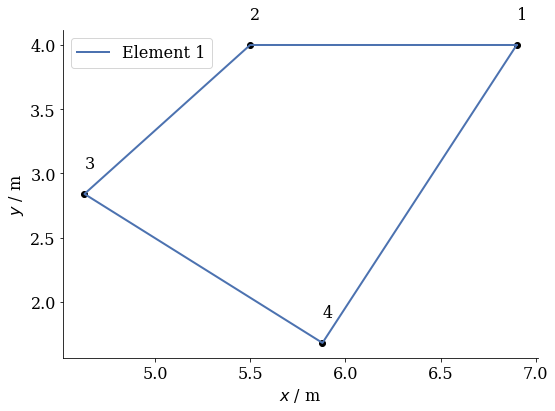

In [56]:
plot_blocks([block1])

Wegen des Schnittprinzips (Kräftegleichgewicht) sind neben der Gewichtskraft bereits folgende Kräfte bekannt: $C_{43} = -C_{34}$, $Q_{43} = - Q_{34}$. Daneben können wir die Kohäsionskraft $C_{41}$ aus der Geometrie des Gleitkörpers ableiten.

In [57]:
G_1 = gravity_vector(blockdata,1)
C_43 = - C_34
Q_43 = - Q_34

In [58]:
C_41 = cohesion(c,geometry,4,1)
print("Die Kohäsionskraft beträgt %.2f kN/m" %np.linalg.norm(C_41))
C_41

Die Kohäsionskraft beträgt 12.67 kN/m


array([ 5.1, 11.6])

Den die Wirkungslinie von $Q_{41}$ charakterisierende Einheitsvektor bestimmen wir wieder durch Rotation der Wirkungslinie der Kohäsionskraft.

In [59]:
e_Q41 = line_of_Q(geometry,Rp,4,1)

Das können wir nun graphisch darstellen.

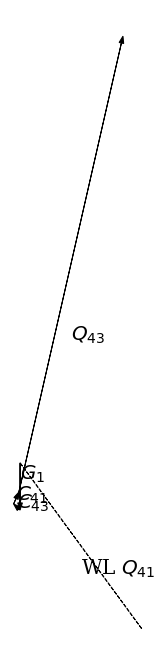

In [60]:
scale = np.linalg.norm(G_1)
fig, ax = plt.subplots(figsize=(12,12))
vec_from_by(ax,delta=G_1,label='$G_1$',scale=scale)
vec_from_by(ax,fro=G_1,delta=C_43,label='$C_{43}$',scale=scale)
vec_from_by(ax,fro=G_1+C_43,delta=C_41,label='$C_{41}$',scale=scale)
vec_from_by(ax,fro=G_1+C_43+C_41,delta=Q_43,label='$Q_{43}$',scale=scale)
#
line_from_by(ax,-e_Q41*200,e_Q41,scale=200,ls='--',label='WL ${Q_{41}}$')
#line_from_by(ax,G_2+C_56+C_54+C_34+Q_56,e_Q34,scale=500,ls='--',label='WL ${Q_{34}}$')
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

Wir sehen, dass sich das Krafteck nicht schließen lässt. Zu diesem Zweck wird auf das letzte Element die vertikale Traglast $P_\text{T}$ eingeführt. Sie hat also die Wirkungslinie

$$
    \vec{e}_{P_\text{T}} = \begin{pmatrix} 0\\-1 \end{pmatrix}
$$

Damit zeichnen wir den Kräfteplan erneut.

In [61]:
e_PT = np.array([0,-1])

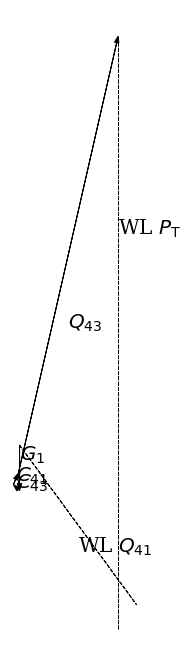

In [62]:
scale = np.linalg.norm(G_1)
fig, ax = plt.subplots(figsize=(12,12))
vec_from_by(ax,delta=G_1,label='$G_1$',scale=scale)
vec_from_by(ax,fro=G_1,delta=C_43,label='$C_{43}$',scale=scale)
vec_from_by(ax,fro=G_1+C_43,delta=C_41,label='$C_{41}$',scale=scale)
vec_from_by(ax,fro=G_1+C_43+C_41,delta=Q_43,label='$Q_{43}$',scale=scale)
#
line_from_by(ax,-e_Q41*200,e_Q41,scale=200,ls='--',label='WL ${Q_{41}}$')
line_from_by(ax,G_1+C_43+C_41+Q_43,e_PT,scale=600,ls='--',label='WL ${P_\\mathrm{T}}$')
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

Nun ergibt sich ein Schnittpunkt. Zur Bestimmung der Traglast, die den gewählten Bruchmechanismus ins Grenzgleichgewicht überführt, lösen wir folgende Vektorgleichung zur Bestimmung des Schnittpunktes der beiden Wirkungslinien:

$$
    \vec{0} = \vec{G}_1 + \vec{C}_{43} + \vec{C}_{41} + Q_{43} + f_{41} \vec{e}_{Q_{41}} + f_{P} \vec{e}_{P_\text{T}}
$$

In [63]:
b1 = -(G_1 + C_43 + C_41 + Q_43)

In [64]:
A1 = np.array([e_Q41,e_PT]).T

In [65]:
f1 = np.linalg.solve(A1,b1)

In [66]:
Q_41 = e_Q41 * f1[0]
print("Die Resultierende beträgt %.2f kN/m" %np.linalg.norm(Q_41))

Die Resultierende beträgt 168.72 kN/m


In [67]:
P_T = e_PT * f1[1]
print("Die Traglast, die das System ins Grenzgleichgewicht überführt, beträgt %.2f kN/m" %np.linalg.norm(P_T))

Die Traglast, die das System ins Grenzgleichgewicht überführt, beträgt 549.96 kN/m


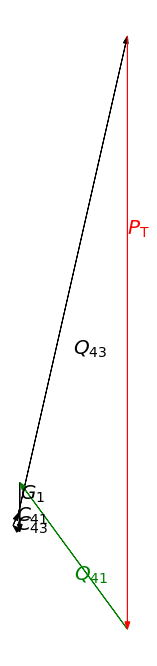

In [68]:
scale = np.linalg.norm(G_1)
fig, ax = plt.subplots(figsize=(12,12))
vec_from_by(ax,delta=G_1,label='$G_1$',scale=scale)
vec_from_by(ax,fro=G_1,delta=C_43,label='$C_{43}$',scale=scale)
vec_from_by(ax,fro=G_1+C_43,delta=C_41,label='$C_{41}$',scale=scale)
vec_from_by(ax,fro=G_1+C_43+C_41,delta=Q_43,label='$Q_{43}$',scale=scale)
#
vec_from_by(ax,-Q_41,Q_41,scale=scale,label='${Q_{41}}$',col='green')
vec_from_by(ax,G_1+C_43+C_41+Q_43,P_T,scale=scale,label='${P_\\mathrm{T}}$',col='red')
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

## Darstellung des Gesamtkräfteplans

Da Kräfte an inneren Gleitfugen sich aufheben (innere Wechselwirkungen), werden im Kräfteplan nur die äußeren Kräfte des Bruchkörpers berücksichtigt. Es ergibt sich folgende Darstellung.

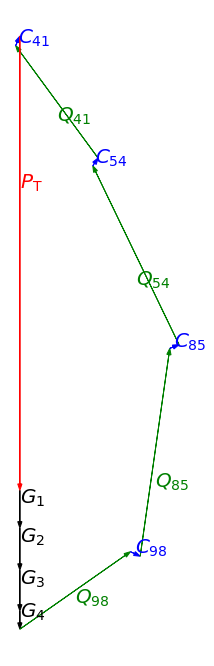

In [69]:
scale = np.linalg.norm(G_2)
fig, ax = plt.subplots(figsize=(12,12))
vec_from_by(ax,delta=G_1,label='$G_1$',scale=scale)
vec_from_by(ax,fro=G_1,delta=G_2,label='$G_2$',scale=scale)
vec_from_by(ax,fro=G_1+G_2,delta=G_3,label='$G_3$',scale=scale)
vec_from_by(ax,fro=G_1+G_2+G_3,delta=G_4,label='$G_4$',scale=scale)
#
vec_from_by(ax,fro=G_1+G_2+G_3+G_4,delta=Q_98,label='$Q_{98}$',scale=scale,col='green')
vec_from_by(ax,fro=G_1+G_2+G_3+G_4+Q_98,delta=C_98,label='$C_{98}$',scale=scale,col='blue')
vec_from_by(ax,fro=G_1+G_2+G_3+G_4+Q_98+C_98,delta=Q_85,label='$Q_{85}$',scale=scale,col='green')
vec_from_by(ax,fro=G_1+G_2+G_3+G_4+Q_98+C_98+Q_85,delta=C_85,label='$C_{85}$',scale=scale,col='blue')
vec_from_by(ax,fro=G_1+G_2+G_3+G_4+Q_98+C_98+Q_85+C_85,delta=Q_54,label='$Q_{54}$',scale=scale,col='green')
vec_from_by(ax,fro=G_1+G_2+G_3+G_4+Q_98+C_98+Q_85+C_85+Q_54,delta=C_54,label='$C_{54}$',scale=scale,col='blue')
vec_from_by(ax,fro=G_1+G_2+G_3+G_4+Q_98+C_98+Q_85+C_85+Q_54+C_54,delta=Q_41,label='$Q_{41}$',scale=scale,col='green')
vec_from_by(ax,fro=G_1+G_2+G_3+G_4+Q_98+C_98+Q_85+C_85+Q_54+C_54+Q_41,delta=C_41,label='$C_{41}$',scale=scale,col='blue')
#
vec_from_by(ax,fro=G_1+G_2+G_3+G_4+Q_98+C_98+Q_85+C_85+Q_54+C_54+Q_41+C_41,delta=P_T,label='$P_\\mathrm{T}$',scale=scale,col='red')
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

## Variation des Bruchmechanismus und Berechnung von Sicherheitsfaktoren bzw. Ausnutzungsgraden

Im Rahmen des Teilsicherheitskonzeptes werden für die Einwirkungen bzw. die Scherparameter Bemessungswerte angesetzt. Diese werden dann mit Ausnutzungsgraden derart verringert, dass die mobilisierten Scherfestigkeitsparameter *ohne zusätzliche Traglast $P_\text{T}$* (in unserem Fall: $P_\text{T} = 0$) gerade zum Grenzgleichgewicht führen. Wie bei den bisherigen Verfahren auch, findet hierbei die Felleniusregel Anwendung.

$$
    \tan \varphi_\text{m} = \mu \tan \varphi_\text{d} \qquad c_\text{m} = \mu c_\text{d}
$$

Im Globalsicherheitskonzept werden hingegen die charakteristischen Werten vermindert. Statt des Ausnutzungsgrades wird üblicherweise dessen Kehrwert, der Sicherheitsfaktor, verwendet:

$$
    \tan \varphi_\text{m} = \frac{\tan \varphi_\text{k}}{\eta} \qquad c_\text{m} = \frac{c_\text{k}}{\eta}
$$

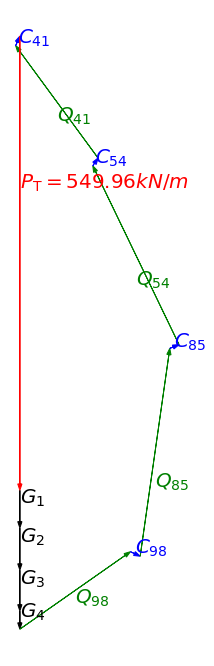

In [70]:
P_T = get_P_T([1],geometry,16,5,30,True)

Nun lässt sich durch Minimierung des Betrags der Traglast $P_\text{T}$ der Sicherheitsfaktor bestimmen.

In [71]:
additional = (geometry,16,5,30,False)
res = sp.optimize.root(fun=get_P_T,x0=1.0,args=additional)
eta_v0 = res.x
print("Der Sicherheitsfaktor für den gegebenen Bruchmechanismus ist %.2f. Das liefert eine zusätzliche Traglast von %.2f kN/m" %(res.x,res.fun))

Der Sicherheitsfaktor für den gegebenen Bruchmechanismus ist 1.89. Das liefert eine zusätzliche Traglast von 0.00 kN/m


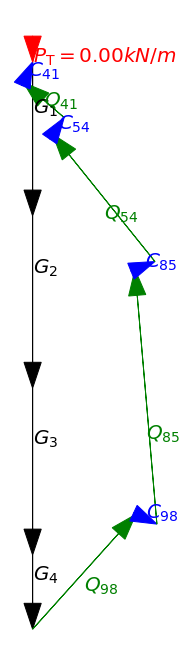

In [72]:
P_T = get_P_T(res.x,geometry,16,5,30,True)

Durch Variation des Bruchmechanismus wird nun derjenige als der kritische identifiziert, der den niedrigsten Sicherheitsfaktor liefert. Dazu fassen wir die oben detailliert dargestellte Berechnung in einer Funktion zusammen. Dies sei hier nur exemplarisch dargestellt. Auch diese Variation kann automatisiert werden, was hier jedoch nicht getan wird.

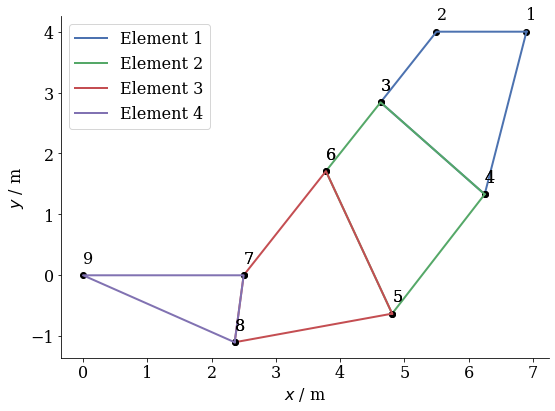

In [73]:
variante1 = pd.DataFrame(np.array([[1,2,3,4,5,6,7,8,9],
                                  [6.9,5.5,4.63,6.25,4.81,3.78,2.5,2.36,0.0],
                                  [4.0,4.0,2.84,1.33,-0.63,1.71,0.0,-1.1,0.0]]).T,
                   columns=['Pkt', 'x / m', 'y / m'])
auto_plot_blocks(variante1)

In [74]:
additional = (variante1,16,5,30,False)
res = sp.optimize.root(fun=get_P_T,x0=1.0,args=additional)
eta_v1 = res.x
print("Der Sicherheitsfaktor für den gegebenen Bruchmechanismus ist %.2f. Das liefert eine zusätzliche Traglast von %.2f kN/m" %(res.x,res.fun))

Der Sicherheitsfaktor für den gegebenen Bruchmechanismus ist 1.98. Das liefert eine zusätzliche Traglast von 0.00 kN/m


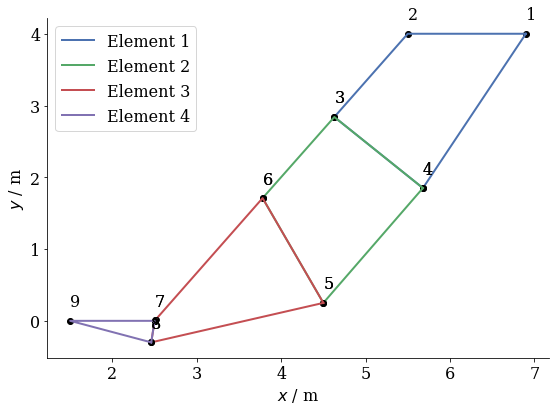

In [75]:
variante2 = pd.DataFrame(np.array([[1,2,3,4,5,6,7,8,9],
                                  [6.9,5.5,4.63,5.68,4.5,3.78,2.5,2.46,1.50],
                                  [4.0,4.0,2.84,1.85,0.25,1.71,0.0,-0.3,0.0]]).T,
                   columns=['Pkt', 'x / m', 'y / m'])
auto_plot_blocks(variante2)

In [76]:
additional = (variante2,16,5,30,False)
res = sp.optimize.root(fun=get_P_T,x0=1.0,args=additional)
eta_v2 = res.x
print("Der Sicherheitsfaktor für den gegebenen Bruchmechanismus ist %.2f. Das liefert eine zusätzliche Traglast von %.2f kN/m" %(res.x,res.fun))

Der Sicherheitsfaktor für den gegebenen Bruchmechanismus ist 1.54. Das liefert eine zusätzliche Traglast von 0.00 kN/m


### Sicherheitsfaktoren aus einer Leistungsbilanzierung

Die Festlegung von Sicherheitsfaktoren ist nicht eindeutig. Man könnte auch die Traglast, die den Grenzzustand herbeiführt, ins Verhältnis zu vorhandenen Lasten setzen. Bei unbelasteten Böschungen sollten für eine sinnvolle Definition noch Gewichtskräfte berücksichtigung finden.

Eine weitere Methode bietet die Bilanzierung der mechanischen Leistung der wirkenden äußeren Lasten (ohne die hypothetische Traglast) $P_\text{A}$ und der Dissipationsleistung der im Grenzzustand wirkenden inneren Kräfte (Reibung und Kohäsion) $P_\text{D}$:

$$
    \eta_P = \frac{P_\text{D}}{P_\text{A}} = \frac{\sum \vec{G}_i \cdot \vec{v}_i}{\sum |\vec{C}_{ij} \cdot \vec{v}_{ij}| + \sum |\vec{Q}_{ij} \cdot \vec{v}_{ij}|}
$$

Mit unterschiedlichen Ansätzen berechnete Sicherheitsfaktoren sind nicht vergleichbar. Eine vergleichende Bewertung geotechnischer Systeme muss daher auf untereinander konsistenten Definitionen fußen. Num im Bruchzustand sollten die geeigneten Definitionen alle den Wert $\eta = 1$ liefern.

In [77]:
P_A = G_1.dot(v_14) + G_2.dot(v_45) + G_3.dot(v_58) + G_4.dot(v_89)
print("Die Leistung der äußeren Kräfte beträgt %.2f kW /m." %P_A)

Die Leistung der äußeren Kräfte beträgt 90.14 kW /m.


In [78]:
P_I = np.abs((C_41+Q_41).dot(v_14)) + np.abs((C_54+Q_54).dot(v_45)) + np.abs((C_85+Q_85).dot(v_58)) + np.abs((C_98+Q_98).dot(v_89)) + \
    np.abs((C_43+Q_43).dot(v_34)) + np.abs((C_56+Q_56).dot(v_65)) + np.abs((C_87+Q_87).dot(v_78))
print("Die Leistung der inneren Kräfte beträgt %.2f kW /m." %P_I)

Die Leistung der inneren Kräfte beträgt 593.59 kW /m.


In [79]:
print("Die aus der Leistung abgeleitete Sicherheit beträgt %.2f" %(P_I/P_A))

Die aus der Leistung abgeleitete Sicherheit beträgt 6.59


Wir vergleichen nun noch einmal den Trend der Ergebnisse.

In [80]:
print("Die Sicherheitsfaktoren aus der Anwendung der Felleniusregel ergaben für die drei Varianten: %.2f, %.2f, %.2f" %(eta_v0,eta_v1,eta_v2))
print("Die Sicherheitsfaktoren aus der Leistungsbilanzierung ergaben für die drei Varianten: %.2f, %.2f, %.2f" 
      %(get_dissipative_safety(geometry,16,5,30),
        get_dissipative_safety(variante1,16,5,30),
        get_dissipative_safety(variante2,16,5,30)
       )
     )


Die Sicherheitsfaktoren aus der Anwendung der Felleniusregel ergaben für die drei Varianten: 1.89, 1.98, 1.54
Die Sicherheitsfaktoren aus der Leistungsbilanzierung ergaben für die drei Varianten: 6.59, 8.92, 3.31


## Aufgaben

* Variieren Sie Kohäsion und Reibungswinkel. Wie ändern sich die Ergebnisse und warum?
* Variieren Sie die Wichte. Wie ändern sich die Ergebnisse und warum?
* Wie wären Effekte durch anstehendes Grundwasser zu berücksichtigen?